## Recommendations code:

In [49]:
import pandas as pd
import numpy as np

### Load in data:

In [50]:
full = pd.read_csv('../data/working_files/strippeddata.csv')
full.head()

,good_logs_num,neutral_logs_num,bad_logs_num,difficulty,terrain,size,status,is_premium,short_description,long_description,...,cache_type_Maze Exhibit,cache_type_Mega event,cache_type_Multi,cache_type_Traditional,cache_type_Unknown/Mystery,cache_type_Virtual,cache_type_Webcam,cache_type_Wherigo,sentiment,index
0,9,0,1,2.0,1.5,1.0,1,1,0,1,...,0,0,0,1,0,0,0,0,0.9730,81005400.09
1,1,3,2,1.5,1.5,2.0,1,0,0,1,...,0,0,0,1,0,0,0,0,0.9797,80987400.49
2,7,2,0,1.5,1.5,2.0,1,0,0,1,...,0,0,0,1,0,0,0,0,-0.9134,80969402.89
3,10,0,0,2.0,3.0,3.0,1,0,1,1,...,0,0,0,0,1,0,0,0,0.9958,80951407.29
4,5,2,0,1.5,2.5,1.0,1,0,0,1,...,0,0,0,1,0,0,0,0,0.9744,80933413.69


In [51]:
df = pd.read_csv('../data/final_files/code_name_label.csv')


In [52]:
xy = pd.read_csv('../data/final_files/coords.csv')

K0 = '0918273645.1425367.908.9012783465'

KEY = [pd.to_numeric(K0[7] +K0[0] +K0[24] +K0[20]+K0[10]+K0[8]), 
       pd.to_numeric(K0[13]+K0[20]+K0[0]  +K0[24]+K0[10]+K0[13]), 
       pd.to_numeric(K0[23]+K0[24]+K0[20] +K0[0] +K0[22]+K0[29])]

def CoordstoCode(xy_list):
    A = [np.power(xy,0.5) for xy in xy_list]
    c_list = [np.round(KEY[1]+aa) if aa%1>0.5 else np.round(KEY[1]-aa) for aa in A]
    c_list = [int(cc) for cc in c_list]
    return c_list

xy['code_index'] = CoordstoCode(list(xy['coords_index']))
xy = xy.sort_values(by='code_index')

df['Y'] = xy['latitude']
df['X'] = xy['longitude']
df.head()

,label,name,code,Y,X
0,1,South River Trail: Triple Claw,GC1A1E7,34.374433,-85.631683
1,49,Canada Traveler Challenge: 5 Provinces,GC92B2K,34.437067,-85.758900
2,47,Milledge Mystery Renewed,GC90JDX,34.435733,-85.754983
3,2,Guarding South Fulton #21,GCH72A,34.688217,-85.526500
4,0,Hottest Park n Ride,GC8D3PX,34.616850,-85.768367


In [53]:
def OtherInfotoCode(z_list):
    A = [np.power(zz,0.5) for zz in z_list]
    c_list = [np.round(KEY[2]+aa) if aa%1>0.5 else np.round(KEY[2]-aa) for aa in A]
    c_list = [int(cc) for cc in c_list]
    return c_list

full = full[['difficulty', 'terrain', 'size', 'hints', 'is_premium', 'index']]
full['code_index'] = OtherInfotoCode(list(full['index']))
full.drop(columns=['index'],inplace=True)
full = full.sort_values(by='code_index')

full.head()

,difficulty,terrain,size,hints,is_premium,code_index
0,2.0,1.5,1.0,0,1,0
1,1.5,1.5,2.0,1,0,1
2,1.5,1.5,2.0,1,0,2
3,2.0,3.0,3.0,1,0,3
4,1.5,2.5,1.0,1,0,4


In [54]:
y_min = df['Y'].min()
y_max = df['Y'].max()
x_min = df['X'].min()
x_max = df['X'].max()
print(f'{y_min}-{y_max} N, {-1*x_max}-{-1*x_min}W')

30.174133-35.177083 N, 81.490367-85.81133299999998W


### Recommendations based on KMeans:

In [55]:
def find_distance(code0,code_recs):
    x0 = list(df[df['code']==code0]['X'])[0]
    y0 = list(df[df['code']==code0]['Y'])[0]
    x = np.array([list(df[df['code']==c]['X'])[0] for c in code_recs]) - x0
    y = np.array([list(df[df['code']==c]['Y'])[0] for c in code_recs]) - y0
    x = (6371*np.cos(y0*np.pi/180)*np.pi/180)*x
    y = (6371*np.pi/180)*y
    distances = np.power((np.power(x,2) + np.power(y,2)),0.5)
    
    return distances
    

In [9]:
def find_clstr_recs(code):
    cluster = list(df[df['code']==code]['label'])[0]
    code_recs = list(df[df['label']==cluster]['code'])
    code_recs.remove(code)
    name_recs = list([list(df[df['code']==c]['name'])[0] for c in code_recs])
    dist_recs = find_distance(code,code_recs)
    
    N = len(code_recs)
    if N > 5:
        chk = pd.DataFrame({'code': code_recs, 'name': name_recs, 'distance': dist_recs})
        chk = chk.sort_values(by='distance')
        chk = chk[0:5]
        code_recs = list(chk['code'])
        name_recs = list(chk['name'])
        dist_recs  = list(chk['distance'])
  
    return code_recs, name_recs, dist_recs

### Recommendations based on Cosine Similarity:

In [10]:
rec1 = pd.read_csv('../data/working_files/recommender1.csv') # based on non-text aspects of the cache, + log sentiment
rec1.head()

,0,1,2,3,4,5,6,7,8,9,...,12423,12424,12425,12426,12427,12428,12429,12430,12431,12432
0,0.000000,1.063022,1.050701,1.420944,0.998758,1.106185,0.906218,1.033566,1.073541,0.752167,...,1.217909,1.151795,1.023544,1.171667,1.058419,1.025897,0.942470,0.962410,1.131513,0.943785
1,1.063022,0.000000,0.837859,1.293393,0.255934,0.468983,0.964311,0.108104,0.116134,0.533808,...,1.256306,1.103369,0.941331,1.025828,1.038530,0.859433,1.210004,1.214650,1.155378,0.594296
2,1.050701,0.837859,0.000000,1.126544,0.838164,0.935861,0.954170,0.862013,0.876246,0.350360,...,1.092241,1.046441,0.990456,1.043356,1.012250,1.005031,1.048107,1.146003,1.064805,0.837889
3,1.420944,1.293393,1.126544,0.000000,1.267423,0.958776,1.002403,1.270507,1.191855,1.304639,...,0.883901,0.908603,1.135949,0.837568,1.173980,1.162204,1.079335,0.835041,0.879847,1.173386
4,0.998758,0.255934,0.838164,1.267423,0.000000,0.219804,0.645744,0.355442,0.554732,0.588293,...,1.158928,1.122530,0.929678,1.044323,0.904917,0.967742,1.216945,1.365808,1.080741,0.435544


In [11]:
rec2 = pd.read_csv('../data/working_files/recommender2.csv') # based on the text of the cache itself
rec2.head()

,0,1,2,3,4,5,6,7,8,9,...,12423,12424,12425,12426,12427,12428,12429,12430,12431,12432
0,0.000000,0.696234,0.983324,0.843118,1.151962,1.121567,1.130816,1.169837,0.916600,1.033493,...,1.013461,1.092586,1.006987,1.165299,1.122696,1.023845,1.214166,1.128579,1.062319,1.234747
1,0.696234,0.000000,0.789297,1.064706,0.840881,0.716581,0.744349,0.958200,0.705462,0.555626,...,0.693019,1.078217,0.529128,1.065446,1.034950,0.538648,0.765856,1.011951,0.702372,0.899089
2,0.983324,0.789297,0.000000,0.974744,0.927177,1.008935,1.021273,1.106764,0.961681,0.982011,...,0.880371,1.113288,0.979076,1.106668,1.064619,0.915111,0.979694,0.791841,1.013619,0.952946
3,0.843118,1.064706,0.974744,0.000000,1.216872,1.156901,1.101516,1.211447,0.941682,1.162350,...,1.190342,0.997088,1.162661,1.204774,1.162577,1.051903,1.275725,1.088580,1.016589,1.309035
4,1.151962,0.840881,0.927177,1.216872,0.000000,0.592858,0.368573,0.590443,0.995469,0.674702,...,0.984417,1.098483,0.669287,1.006552,0.707267,0.680697,0.555366,0.953864,0.913476,0.749871


In [12]:
ndexs = list(df.index)
codes = list(df['code']) 
code_index = {codes[n]:ndexs[n] for n in range(df.shape[0])}
index_code = {ndexs[n]:codes[n] for n in range(df.shape[0])}


In [13]:
def find_cos_recs(code,recommender):
    code_no = str(code_index[code])
    recs = list(recommender[[code_no]].sort_values(by=code_no).index)[1:6]    
    cdis_recs = list(recommender[[code_no]].sort_values(by=code_no)[code_no])[1:6]    
    code_recs = [df['code'][r] for r in recs]
    name_recs = [df['name'][r] for r in recs]
    dist_recs = find_distance(code,code_recs)
    
    return code_recs, name_recs, dist_recs, cdis_recs

### Test them out:

In [14]:
code_recs, name_recs, dist_recs, cdis_recs = find_cos_recs('GC1A1E7',rec1)
pd.DataFrame({'code':code_recs, 'name':name_recs, 'dist':dist_recs, 'cos dist':cdis_recs})

,code,name,dist,cos dist
0,GC2Q4CD,Georgia I-95 Solar System - Rhea,336.394398,0.018808
1,GC8ZQ7E,Hello I'm Johnnie's Cache,187.326713,0.029682
2,GC2ZG54,All Roads Lead to Rome Iter VIII,81.180976,0.029757
3,GC8A5MG,Relic,146.703339,0.029767
4,GC4M1E2,Greek Redux - Omega,334.241714,0.029903


In [15]:
code_recs, name_recs, dist_recs, cdis_recs = find_cos_recs('GC1A1E7',rec2)
pd.DataFrame({'code':code_recs, 'name':name_recs, 'dist':dist_recs, 'cos dist':cdis_recs})

,code,name,dist,cos dist
0,GC3DKX6,Huckleberry Nature Trail 1,337.723153,0.384754
1,GC63HKX,Thomasville History Series - Charlie Ward Jr.,364.260453,0.419490
2,GC9697J,Cherokee 336,140.215883,0.432532
3,GC64EP8,Reservoir Overlook,544.229656,0.434289
4,GC6YAFP,Tricky Trickum,118.904801,0.439772


In [16]:
code_recs, name_recs, dist_recs = find_clstr_recs('GC1A1E7')
pd.DataFrame({'code':code_recs, 'name':name_recs, 'dist':dist_recs})

,code,name,dist
0,GC44KZ6,(Not THAT) Beaver Cache,5.601745
1,GC44NXP,SRT: UTP,11.155993
2,GC11HRX,B and B Little Chicken,11.333359
3,GC1W1YB,Black Cat Tips,12.329361
4,GC5VXDK,Under the Boardwalk,19.771443


In [17]:
def get_params(code_list):
    
    difficulties = []
    terrains     = []
    sizes        = []
    hints        = []
    premiums     = []
    for code in code_list:
        code_no = code_index[code]
        params = list(full.loc[code_no])
        difficulties.append(params[0])
        terrains.append(params[1])
        sizes.append(params[2])
        hints.append(params[3])
        premiums.append(params[4])
        
    return difficulties, terrains, sizes, hints, premiums

In [18]:
def get_kclusters(code,code_list):
    cluster0 = list(df[df['code']==code]['label'])[0]
    clusters = [1 if list(df[df['code']==c]['label'])[0]==cluster0 else 0 for c in code_list]
    return clusters

In [19]:

def display_results(code):
    
    code_recs1, name_recs1, dist_recs1, pdis_recs1 = find_cos_recs(code,rec1)
    tdis_recs1 = ['' for c in code_recs1]
    cltr_recs1 = get_kclusters(code,code_recs1)
    diff_recs1, terr_recs1, size_recs1, hint_recs1, prem_recs1 = get_params(code_recs)
    dist_recs1 = list(dist_recs1)

    code_recs2, name_recs2, dist_recs2, tdis_recs2 = find_cos_recs(code,rec2)
    pdis_recs2 = ['' for c in code_recs2]
    cltr_recs2 = get_kclusters(code,code_recs2)
    diff_recs2, terr_recs2, size_recs2, hint_recs2, prem_recs2 = get_params(code_recs2)
    dist_recs2 = list(dist_recs2)

    code_recs3, name_recs3, dist_recs3 = find_clstr_recs(code)
    pdis_recs3 = ['' for c in code_recs3]
    tdis_recs3 = ['' for c in code_recs3]
    cltr_recs3 = [1 for c in code_recs3]
    diff_recs3, terr_recs3, size_recs3, hint_recs3, prem_recs3 = get_params(code_recs3)
    dist_recs3 = list(dist_recs3)

    chk = pd.DataFrame({
        'code'          : code_recs1 + code_recs2 + code_recs3,
        'name'          : name_recs1 + name_recs2 + name_recs3,
        'distance'      : dist_recs1 + dist_recs2 + dist_recs3,
        'cos dist P'    : pdis_recs1 + pdis_recs2 + pdis_recs3,
        'cos dist T'    : tdis_recs1 + tdis_recs2 + tdis_recs3,
        'cluster match' : cltr_recs1 + cltr_recs2 + cltr_recs3,
        'difficulty'    : diff_recs1 + diff_recs2 + diff_recs3,
        'terrain'       : terr_recs1 + terr_recs2 + terr_recs3,
        'size'          : size_recs1 + size_recs2 + size_recs3,
        'hint'          : hint_recs1 + hint_recs2 + hint_recs3,
        'premium'       : prem_recs1 + prem_recs2 + prem_recs3
    })
    #print(chk)
    return chk


In [20]:
ndx_list = [10, 40, 55, 540, 1000, 4958, 5002]
codes = [df.loc[n]['code'] for n in ndx_list]

for code in codes:

    chk = display_results(code)
    print()
    print(code)

    


GC8N2JF

GCZBNW

GC44MYY

GCPB7G

GC49XGA

GC8J18J

GC97BDK


In [21]:
codes0 = list(df['code'])
codes = [codes0[n] for n in range(0,12433,200)]

N_kmeans = []
N_match1 = []
N_match2 = []
for n,code in enumerate(codes):
    chk = display_results(code)
    cluster_matches = list(chk['cluster match'])
    N_kmeans.append(chk.shape[0]-10)
    N_match1.append(chk['cluster match'][0:5].sum())
    N_match2.append(chk['cluster match'][5:10].sum())
    if n%5==0: print(f'Appended {n} of {len(codes)} caches...')

Appended 0 of 63 caches...
Appended 5 of 63 caches...
Appended 10 of 63 caches...
Appended 15 of 63 caches...
Appended 20 of 63 caches...
Appended 25 of 63 caches...
Appended 30 of 63 caches...
Appended 35 of 63 caches...
Appended 40 of 63 caches...
Appended 45 of 63 caches...
Appended 50 of 63 caches...
Appended 55 of 63 caches...
Appended 60 of 63 caches...


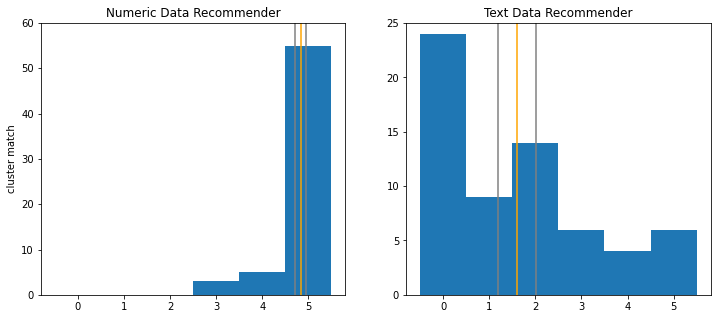

In [27]:
N_match1_corrected = [m for n,m in enumerate(N_match1) if N_kmeans[n]>0]
N_match2_corrected = [m for n,m in enumerate(N_match2) if N_kmeans[n]>0]

import matplotlib.pyplot as plt

bins = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
fig = plt.figure(figsize=(12,5));
ax = fig.add_subplot(121);
plt.hist(N_match1_corrected,bins = bins);
plt.title('Numeric Data Recommender');
plt.ylabel('cluster match');
plt.plot([4.71, 4.71],[0, 60],color='grey');
plt.plot([4.83, 4.83],[0, 60],color='orange');
plt.plot([4.95, 4.95],[0, 60],color='grey');
plt.ylim([0, 60]);
ax = fig.add_subplot(122);
plt.hist(N_match2_corrected,bins=bins);
plt.title('Text Data Recommender');
plt.plot([1.19, 1.19],[0, 25],color='grey');
plt.plot([1.60, 1.60],[0, 25],color='orange');
plt.plot([2.01, 2.01],[0, 25],color='grey');
plt.ylim([0, 25]);


It seems that the PARAMETER based cosine distance recommender tends to overlap with the Kmeans clusters; not so much with the text based cosine distance recommender. 

So, I will take the parameter based cosine distance recommendations, and the kmeans recommendations, for my joint recommender.

In [23]:
sample_mean = np.mean(N_match1_corrected)
sigma = np.std(N_match1_corrected)
n = len(N_match1_corrected)
m_error = 1.96*sigma/np.sqrt(n)
ul = sample_mean + m_error
ll = sample_mean - m_error
print('parameter recommender')
print([ll, ul])
print(f'{sample_mean} +/- {m_error}')
print()

sample_mean = np.mean(N_match2_corrected)
sigma = np.std(N_match2_corrected)
n = len(N_match2_corrected)
m_error = 1.96*sigma/np.sqrt(n)
ul = sample_mean + m_error
ll = sample_mean - m_error
print('text recommender')
print([ll, ul])
print(f'{sample_mean} +/- {m_error}')
print()


parameter recommender
[4.704585666653862, 4.946207984139789]
4.825396825396825 +/- 0.12081115874296364

text recommender
[1.1962496362956831, 2.0100995700535234]
1.6031746031746033 +/- 0.40692496687892



In [28]:
rec1.head()

,0,1,2,3,4,5,6,7,8,9,...,12423,12424,12425,12426,12427,12428,12429,12430,12431,12432
0,0.000000,1.063022,1.050701,1.420944,0.998758,1.106185,0.906218,1.033566,1.073541,0.752167,...,1.217909,1.151795,1.023544,1.171667,1.058419,1.025897,0.942470,0.962410,1.131513,0.943785
1,1.063022,0.000000,0.837859,1.293393,0.255934,0.468983,0.964311,0.108104,0.116134,0.533808,...,1.256306,1.103369,0.941331,1.025828,1.038530,0.859433,1.210004,1.214650,1.155378,0.594296
2,1.050701,0.837859,0.000000,1.126544,0.838164,0.935861,0.954170,0.862013,0.876246,0.350360,...,1.092241,1.046441,0.990456,1.043356,1.012250,1.005031,1.048107,1.146003,1.064805,0.837889
3,1.420944,1.293393,1.126544,0.000000,1.267423,0.958776,1.002403,1.270507,1.191855,1.304639,...,0.883901,0.908603,1.135949,0.837568,1.173980,1.162204,1.079335,0.835041,0.879847,1.173386
4,0.998758,0.255934,0.838164,1.267423,0.000000,0.219804,0.645744,0.355442,0.554732,0.588293,...,1.158928,1.122530,0.929678,1.044323,0.904917,0.967742,1.216945,1.365808,1.080741,0.435544


In [29]:
rec1['ndx'] = rec1.index

In [37]:
list(rec1[['2', 'ndx']].sort_values(by='2')['ndx'])[1]


2546

In [38]:
min_max = []
for n in range(12433):
    temp = {
        'cache': n,
        'n_min': list(rec1[[str(n), 'ndx']].sort_values(by=str(n))['ndx'])[1],
        'minCD': list(rec1[[str(n), 'ndx']].sort_values(by=str(n))[str(n)])[1],
        'n_max': list(rec1[[str(n), 'ndx']].sort_values(by=str(n))['ndx'])[12432],
        'maxCD': list(rec1[[str(n), 'ndx']].sort_values(by=str(n))[str(n)])[12432]
            }
    min_max.append(temp)
    if n%500==0: print(n)
    

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000


In [41]:
pd.DataFrame(min_max).sort_values(by='maxCD').tail()

,cache,n_min,minCD,n_max,maxCD
7056,7056,930,0.028726,9603,1.782178
9932,9932,4297,0.082106,2671,1.785954
2671,2671,6093,0.006308,9932,1.785954
11,11,3413,0.050125,2552,1.792110
2552,2552,2135,0.027005,11,1.792110


11388, 11420 <-- very similar (CD = 0.0)

2552, 11 <-- very different (CD = 1.792)

In [44]:
rec1[rec1['ndx']==11420]['11388']

11420    0.0
Name: 11388, dtype: float64

In [46]:
index_code[11388], index_code[11420]

('GC7J0J4', 'GC7J2ZH')

In [48]:
index_code[2552], index_code[11]

('GC2553F', 'GC8N2K8')